In [21]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal y a un Decision Tree. El objetivo de hoy es:

 - Ajustar el modelo a un Random Forest
 - Extraer las métricas
 - Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [22]:
df=pd.read_csv('../datos/salarios_encoding_dum.csv', index_col=0)
df.head(2) #Hacemos una vista previa de nuestro DataFrame

,salary_box,experience_levelmap_funcion,emp_resid_CA,emp_resid_ES,emp_resid_FR,emp_resid_GB,emp_resid_IN,emp_resid_US
0,4631.904560,1,0,0,0,0,0,1
1,7311.922975,2,0,0,0,0,0,1


In [23]:
df.shape

(311, 8)

In [24]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.drop("salary_box", axis = 1)
y = df["salary_box"]

In [25]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Ajustamos el modelo

In [26]:
# recordamos que lo primero que hacíamos era crear un diccionario con los hiperparámetros que queríamos probar

param = {"max_depth": [1,2, 3], 
        "max_features": [1,2],
        "min_samples_split": [10, 25, 50],
        "min_samples_leaf": [10,25,50]} 

In [27]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [ ]:
# ajustamos el modelo que acabamos de definir en el GridSearch
# 🚨 Esta celda puede tardar en ejecutarse

gs_rf.fit(x_train, y_train)

In [ ]:

bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=3, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

#### 🚨🚨 Por motivos de rendimiento de seguridad de nuestro ordenador no vamos a plotear los árboles ya que existe el riesgo de petar el ordenador. 🚨🚨

In [ ]:
# dibujemos los árboles de nuestro bosque


#for arbol in tqdm(bosque.estimators_):
#    fig = plt.figure(figsize=(40, 20))
#    tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)
#   plt.show()

In [ ]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [ ]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [ ]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,1083.696442,2.087700e+06,1444.887375,0.465847,test,Random Forest
1,1226.725295,2.352825e+06,1533.892145,0.490237,train,Random Forest


In [ ]:

df_linear_results = pd.read_csv("../datos/resultados_salarys.csv", index_col = 0)
df_linear_results

,MAE,MSE,RMSE,R2,set,modelo
0,1074.127184,2.045892e+06,1430.346970,0.476543,test,Linear Regresion
1,1152.579168,2.117210e+06,1455.063529,0.541285,train,LinearRegression


In [ ]:
# concatenamos el csv anterior con los resultados obtenidos en este modelo

df_todos_resultados = pd.concat([dt_results, df_linear_results], axis = 0)
df_todos_resultados

,MAE,MSE,RMSE,R2,set,modelo
0,1083.696442,2.087700e+06,1444.887375,0.465847,test,Random Forest
1,1226.725295,2.352825e+06,1533.892145,0.490237,train,Random Forest
0,1074.127184,2.045892e+06,1430.346970,0.476543,test,Linear Regresion
1,1152.579168,2.117210e+06,1455.063529,0.541285,train,LinearRegression


In [ ]:

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,emp_resid_US,0.601016
0,experience_levelmap_funcion,0.345089
4,emp_resid_GB,0.040877
5,emp_resid_IN,0.009429
1,emp_resid_CA,0.003588
2,emp_resid_ES,0.000000
3,emp_resid_FR,0.000000


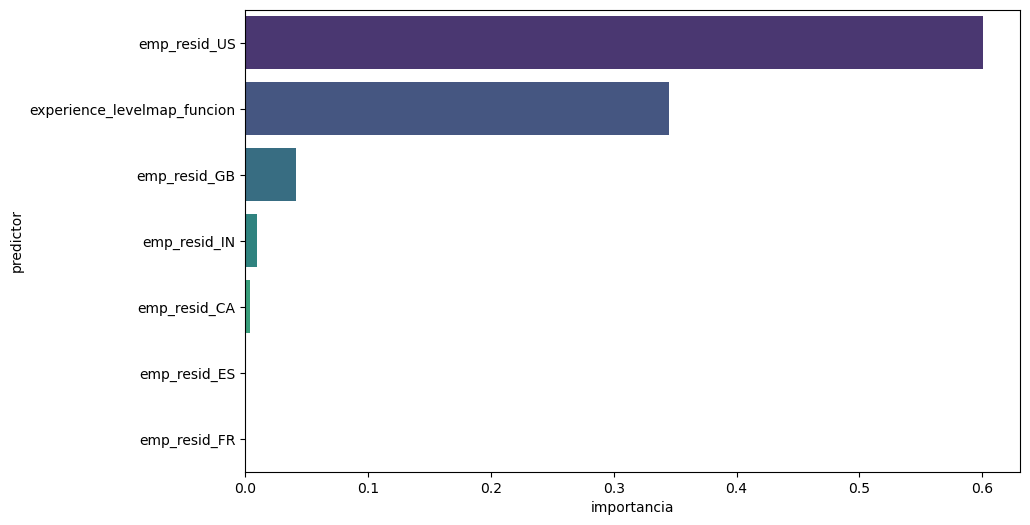

In [ ]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

En conclusión de este último módelo podemos sacar las mismas conclusiones que en el de Dessicion Tree, que de nuevo vemos unas metricas muy malas con un MSE muy elevadas y un R2 inferior a 0.70, al igual que hemos comentado en las conclusiones previas vemos la necesidad hacer nuestro modelo pero con otra filtración que vaya para cada continente y hacer las predicciones especificas para cada uno.

Como conclusión final, en la regresión final ya se veía que el modelo no se ajustaba a nuestros datos, pero podíamos pensar que con un desicion tree o un random forest se ajustaría mejor, a pesar de nuestras sospechas sobre el ajuste de los datos. Cuando aplicamos estos dos algoritmos, confirmamos la sospecha que veíamos y vemos la necesidad de ajustar el modelo por cada continente, al tener numero de muestras distintas.